In [1]:
# References
# https://medium.com/swlh/introduction-to-cnn-image-classification-using-cnn-in-pytorch-11eefae6d83c
# https://towardsdatascience.com/how-i-built-a-face-mask-detector-for-covid-19-using-pytorch-lightning-67eb3752fd61
# https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
# https://core.ac.uk/reader/328808130

In [2]:
# Importing libraries
import os
import cv2
import torch
import itertools
import numpy as np
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage, Compose, ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, Subset
from sklearn.model_selection import KFold

In [3]:
# Path of training and testing dataset
drive.mount('/content/drive') # comment out while running locally
dir_path = "/content/drive/My Drive/COMP-6721-AI-Project-2/Dataset" # update directory path for local directory

mask_dir = "{}/person_with_mask".format(dir_path)
mask_female_dir = "{}/Female".format(mask_dir)
mask_male_dir = "{}/Male".format(mask_dir)

non_mask_dir = "{}/person".format(dir_path)
non_mask_female_dir = "{}/Female".format(non_mask_dir)
non_mask_male_dir = "{}/Male".format(non_mask_dir)

not_person_dir = "{}/not_person".format(dir_path)

procesed_dir = "{}/processed_data_part2.npy".format(dir_path) # stored pre-processed data as npy file for running again

save_model_name = "ai-project-part-2"

testing_dir_path = "/content/drive/My Drive/COMP-6721-AI-Project-2/TestDataset"

test_mask_dir = "{}/person_with_mask".format(testing_dir_path)
test_mask_female_dir = "{}/Female".format(test_mask_dir)
test_mask_male_dir = "{}/Male".format(test_mask_dir)

test_non_mask_dir = "{}/person".format(testing_dir_path)
test_non_mask_female_dir = "{}/Female".format(test_non_mask_dir)
test_non_mask_male_dir = "{}/Male".format(test_non_mask_dir)

test_not_person_dir = "{}/not_person".format(testing_dir_path)

test_procesed_dir = "{}/test_processed_data_part2.npy".format(testing_dir_path)
test_female_processed_dir = "{}/test_female_processed_data_part2.npy".format(testing_dir_path)
test_male_processed_dir = "{}/test_male_processed_data_part2.npy".format(testing_dir_path)

Mounted at /content/drive


In [4]:
# Labels (classes) to differentiate the images in these categories
label_dict = {
    0: "Person with Face Mask", 
    1: "Person without Face Mask", 
    2: "Not a Person"
}

# Labels to display on the confussion matrix
labels_list = ["Person with Face Mask", "Person without Face Mask", "Not a Person"]

In [5]:
# Customized dataset class named ProjectDataset which is inherited
# from Dataset class of pytorch, the purpose of inheritance here is 
# to store the labels(keys) of images with the image ndarray this way we
# can remove the problem of overfitting. This overfitting problem was there
# when initially project implementation started as we have purposely devided
# images of different lables/classes in different directories.
class ProjectDataset(Dataset):

    def __init__(self, data):
        self.data = data
        self.transformations = Compose([
            ToTensor()
        ])

    def __getitem__(self, key):
        item_list = []
        try:
            item_list.append(self.transformations(self.data[key][0]))
            item_list.append(torch.tensor(self.data[key][1]))
        except Exception:
            pass
        return item_list

    def __len__(self):
        return self.data.__len__()

In [6]:
# Customized convolution neural network class which is again inherited from the torch
# neural network class. this class contains all the filters and other operations
# which are performed on images. The class contains forward method which is used to
# feedforward the neural network and the backpropogation.
class COMP_6721_CNN(nn.Module):
    
    def __init__(self):
        super(COMP_6721_CNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            # convolution layer 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(p=0.02),

            # convolution layer 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(p=0.02),
            
            # convolution layer 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(p=0.02),
            
            # convolution layer 3
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(p=0.05)
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(18432, 3)
        )

    # forward pass to readjust weights  
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [7]:
# This function takes empty data as list, directory path to find the dataset
# location and key which used to describe the category of image (0, 1, 2) based 
# on the which class it belongs. after converting images into an array the function
# will return all the array within list to process further.
def load_images(data, dir_path, key):
    print("=== Loading Images ===")
    for file_path in os.listdir(dir_path):
        try:
            temp_img = cv2.resize(cv2.imread("{}/{}".format(dir_path, file_path), cv2.IMREAD_COLOR), (100, 100))
            data.append([np.array(temp_img), key])
        except Exception as e:
            pass
    return data

In [8]:
# This function takes image data as a list and saving data directory path and after
# shuffling the data, it will store numpy array at the specific directory.
def shuffle_and_save_data(data, save_data_dir):
    print("=== Shuffel Images ===")
    np.random.shuffle(data)
    np.save(save_data_dir, data)

In [9]:
# This function takes process and stored data dictionary path, after reading data
# from the given path, the function distributes data across training and testing data category.
# It combines all the data with a key and returns a dictionary for the further use.

# def load_and_distribute_data(procesed_dir):
#     print("=== Loading and Distributing Images across Training and Testing data ===")
#     loaded_data = np.load(procesed_dir, allow_pickle=True)
#     training_data, testing_data = train_test_split(loaded_data, test_size=0.2, random_state=0)
#     distributed_data = {
#         "training_data": training_data,
#         "testing_data": testing_data
#     }
#     return distributed_data

In [10]:
# This function takes process and stored data dictionary path, after reading data
# from the given path, the function distributes data and returns a dictionary for the further use.
def load_and_distribute_data_v2(procesed_dir):
    print("=== Loading and Distributing Images data V2 ===")
    loaded_data = np.load(procesed_dir, allow_pickle=True)
    distributed_data = {
        "loaded_data": loaded_data
    }
    return distributed_data

In [11]:
# This function takes a dictionary of keys (label classes) along with the
# data for all clasess and builds the loader for each training and testing
# category and returns it for further use.

# def build_dataset_loaders(distributed_data):
#     print("=== Bulding Data Loaders ===")
#     training_dataset = ProjectDataset(distributed_data.get("training_data"))
#     test_dataset = ProjectDataset(distributed_data.get("testing_data"))
#     train_loader = DataLoader(training_dataset, batch_size=128)
#     test_loader = DataLoader(test_dataset, batch_size=128)
#     return train_loader, test_loader

In [12]:
# This function takes a dictionary of keys along with the
# data and builds the loader for each training and testing
# category and returns it for further use.
def build_dataset_loaders_v2(distributed_data):
    print("=== Bulding Data Loaders V2 ===")
    dataset = ProjectDataset(distributed_data.get("loaded_data"))
    return dataset

In [13]:
def build_KFold_Iterator(dataset, model, optimizer, loss_criteria):
    kfold = KFold(n_splits=10, shuffle=True, random_state=None)
    fold_val = 1
    for training_idx, testing_idx in kfold.split(dataset):
        print("Running Fold Num: ", fold_val)
        training_dataset = Subset(dataset, training_idx)
        testing_dataset = Subset(dataset, testing_idx)
        training_loader = DataLoader(training_dataset, batch_size=128, num_workers=0,shuffle=True)
        testing_loader = DataLoader(testing_dataset, batch_size=128, num_workers=0, shuffle=True)
        return_model = train_model(model, optimizer, loss_criteria, training_loader, 10)
        test_model(model, testing_loader)
        fold_val+=1
    return return_model, training_loader

In [14]:
# This function takes training data and returns a normalized list based on
# number of data falls into each category/label (classes) which is used while
# building a loss criteria.
def normalized_weights_to_build_loss_criteria(training_data):
    print("=== Normalizing weights accorss all Label classes ===")
    # Dict to count number of training images across the different classes
    # for normalization purpose
    training_data_count_dict = {
        0: 0,
        1: 0,
        2: 0
    }
    normalization_values = []
    for data in training_data:
        training_data_count_dict.update({data[1]: training_data_count_dict.get(data[1])+1})
    categorized_value_list = list(training_data_count_dict.values())
    total_counts = sum(categorized_value_list)
    for category_value in categorized_value_list:
        key_value = (1 - (category_value / total_counts))
        normalization_values.append(key_value)
    return normalization_values

In [15]:
# This function takes a device and normalizeed list to build a model.
def build_model(device, normalization):
    print("=== Bulding Model ===")
    model = COMP_6721_CNN()
    model = model.to(device)
    loss_criteria = nn.CrossEntropyLoss(weight=torch.tensor(normalization).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return model, optimizer, loss_criteria

In [16]:
# This function takes a model, optimizer, loss_criteria and training loader to 
# train the model, after multiple epoches, model gets stablize and function return
# the model to use it for evaluation.
def train_model(model, optimizer, loss_criteria, train_loader, num_epoch=10):
    print("=== Training Model ===")
    for i in range(num_epoch):
        model.train()
        training_accuracy_list = []
        training_loss_list = []

        for data_chunk in train_loader:
            images, labels = data_chunk
            outputs = model(images)
            training_loss = loss_criteria(outputs, labels.long())
            _, prediction_vals = torch.max(outputs, dim=1)
            training_accuracy = torch.tensor(torch.sum(prediction_vals == labels).item() / len(prediction_vals))
            training_accuracy_list.append(training_accuracy)
            training_loss_list.append(training_loss)
            training_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("Epoch: {}, training loss: {}, training accuracy: {}".format(
            i+1, torch.stack(training_loss_list).mean().item(), torch.stack(training_accuracy_list).mean().item()
        ))
    return model

In [17]:
def test_model(model, testing_loader):
    print("=== Testing model ===")
    model.eval()
    predictions_list = []
    accurate_list = []
    with torch.no_grad():
        for data_chunk in testing_loader:
            images, labels = data_chunk
            _, pred_values = torch.max(model(images), dim=1)
            predictions_list.extend(pred_values.detach().cpu().numpy())
            accurate_list.extend(labels.detach().cpu().numpy())
    test_accuracy = ((np.array(accurate_list)==np.array(predictions_list)).sum().item()/len(accurate_list))*100
    print('Accuracy : {}'.format(test_accuracy))

In [18]:
# This function takes model and model name and saves the model at given directory
# location.
def save_model(model, dir_path, save_model_name):
    print("=== Saving Model ===")
    torch.save(model.state_dict(), "{}/{}".format(dir_path, save_model_name))

In [19]:
# This function takes directory and model name to load the stored model from
# given name and location.
def load_saved_model(dir_path, device, save_model_name):
    print("=== Loading saved Model ===")
    loaded_model = torch.load("{}/{}".format(dir_path, save_model_name), map_location=device)
    model = COMP_6721_CNN()
    model.load_state_dict(loaded_model)
    model = model.to(device)
    return model

In [20]:
# This function takes a model follwed by title of report and matrix and the data loader 
# which is either training and testing data loader. It calculates the accuracy
# and displays the classification report based on actual and predicted label. The report
# contains F1, Recall, Precision values and followed by Confussion matrix to compare the
# actual and predicted results.
def generate_classification_report_and_plot_confusion_matrix(model, title, dataset):
    print("\n=== Generating Classification Report ===")
    model.eval()
    predictions_list = []
    accurate_list = []
    data_loader = DataLoader(dataset, batch_size=128, num_workers=0,shuffle=True)
    with torch.no_grad():
        for data_chunk in data_loader:
            images, labels = data_chunk
            _, pred_values = torch.max(model(images), dim=1)
            predictions_list.extend(pred_values.detach().cpu().numpy())
            accurate_list.extend(labels.detach().cpu().numpy())
    print("{} Classification Report".format(title))
    print(classification_report(accurate_list, predictions_list))
    print("=== Generating Confusion Matrix ===")
    plt.figure()
    confusion_matrix_instance = confusion_matrix(accurate_list, predictions_list)
    plt.imshow(confusion_matrix_instance, interpolation='nearest', cmap=plt.cm.Pastel2)
    for (x_cordinate, y_cordinate), val in np.ndenumerate(confusion_matrix_instance):
        plt.text(x_cordinate, y_cordinate, val, ha='center', va='center')
    plt.title('{} Confusion matrix'.format(title))
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    randomized_val = np.arange(len(labels_list))
    plt.xticks(randomized_val, labels_list, rotation=60)
    plt.yticks(randomized_val, labels_list)

In [21]:
# This function takes a model and the data loader and it will display some sample images
# with actual and predicted results.
def generate_predicted_result(model, dataset):
    print("=== Generating Predicted Results ===")
    _, axes = plt.subplots(1, 6, figsize=(25, 25))
    sample_predictions_list = []
    sample_accurate_list = []
    data_loader = DataLoader(dataset, batch_size=128, num_workers=0,shuffle=True)
    with torch.no_grad():
        for data_chunk in data_loader:
            images, labels = data_chunk
            _, pred_values = torch.max(model(images), dim=1)
            sample_predictions_list.extend(pred_values.detach().cpu().numpy())
            sample_accurate_list.extend(labels.detach().cpu().numpy())
            c=0
            random_index=np.random.uniform(low=0, high=127, size=(6,)).astype(int)
            for num in random_index:
                sample_img = images[num].detach().cpu().numpy().transpose(1, 2, 0)
                axes[c].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
                axes[c].set_title("{0}".format(labels_list[sample_predictions_list[num]]), fontsize=14)
                c+=1
            plt.show(block=True)
            return

In [22]:
# This function is treated as a main function to run the program. The function takes
# two boolean parameters is_data_preloaded and is_model_saved. If the value of is_data_preloaded
# is True which means program reads pre-loaded data from the directory, otherwise it generates
# the data and loads it. While the True value of is_model_saved parameter indicates that
# program reads model from the directory which is pre stored and if the parameter is set as 
# False then it creates new model, trains the model and then it becomes available for 
# further use such as in evaluation process.
def run_program(
    is_data_preloaded = False, 
    is_model_saved = False
):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    if not is_data_preloaded:
        data = []
        data = load_images(data, mask_female_dir, 0)
        data = load_images(data, mask_male_dir, 0)
        data = load_images(data, non_mask_female_dir, 1)
        data = load_images(data, non_mask_male_dir, 1)
        data = load_images(data, not_person_dir, 2)
        shuffle_and_save_data(data, procesed_dir)
        
        # Testing data which is not used in training purpose anyhow
        test_data = []
        test_data = load_images(test_data, test_mask_female_dir, 0)
        test_data = load_images(test_data, test_mask_male_dir, 0)
        test_data = load_images(test_data, test_non_mask_female_dir, 1)
        test_data = load_images(test_data, test_non_mask_male_dir, 1)
        test_data = load_images(test_data, test_not_person_dir, 2)
        shuffle_and_save_data(test_data, test_procesed_dir)
        
        # Testing Female data which is not used in training purpose anyhow
        test_data_female = []
        test_data_female = load_images(test_data_female, test_mask_female_dir, 0)
        test_data_female = load_images(test_data_female, test_non_mask_female_dir, 1)
        shuffle_and_save_data(test_data_female, test_female_processed_dir)
        
        # Testing Male data which is not used in training purpose anyhow
        test_data_male = []
        test_data_male = load_images(test_data_male, test_mask_male_dir, 0)
        test_data_male = load_images(test_data_male, test_non_mask_male_dir, 1)
        shuffle_and_save_data(test_data_male, test_male_processed_dir)
        
    # distributed_data = load_and_distribute_data(procesed_dir)
    distributed_data = load_and_distribute_data_v2(procesed_dir)
    dataset = build_dataset_loaders_v2(distributed_data)
    
    # Testing data loading which is not used in training purpose anyhow
    test_distributed_data = load_and_distribute_data_v2(test_procesed_dir)
    test_dataset = build_dataset_loaders_v2(test_distributed_data)
    
    # Testing FEMALE data loading which is not used in training purpose anyhow
    test_female_distributed_data = load_and_distribute_data_v2(test_female_processed_dir)
    test_female_dataset = build_dataset_loaders_v2(test_female_distributed_data)
    
    # Testing MALE data loading which is not used in training purpose anyhow
    test_male_distributed_data = load_and_distribute_data_v2(test_male_processed_dir)
    test_male_dataset = build_dataset_loaders_v2(test_male_distributed_data)
    
    if not is_model_saved:
        # normalization = normalized_weights_to_build_loss_criteria(distributed_data.get("training_data"))
        normalization = normalized_weights_to_build_loss_criteria(distributed_data.get("loaded_data"))
        model, optimizer, loss_criteria = build_model(device, normalization)
        # model = train_model(model, optimizer, loss_criteria, train_loader)
        model, training_loader = build_KFold_Iterator(dataset, model, optimizer, loss_criteria)
        save_model(model, dir_path, save_model_name)
        
    model = load_saved_model(dir_path, device, save_model_name)
    
    generate_classification_report_and_plot_confusion_matrix(model, "Training", dataset)
    
    generate_classification_report_and_plot_confusion_matrix(model, "Testing", test_dataset)
    generate_predicted_result(model, test_dataset)
    
    generate_classification_report_and_plot_confusion_matrix(model, "Female Test Dataset", test_female_dataset)
    generate_predicted_result(model, test_female_dataset)
    
    generate_classification_report_and_plot_confusion_matrix(model, "Male Test Dataset", test_male_dataset)
    generate_predicted_result(model, test_male_dataset)

=== Loading and Distributing Images data V2 ===
=== Bulding Data Loaders V2 ===
=== Loading and Distributing Images data V2 ===
=== Bulding Data Loaders V2 ===
=== Loading and Distributing Images data V2 ===
=== Bulding Data Loaders V2 ===
=== Loading and Distributing Images data V2 ===
=== Bulding Data Loaders V2 ===
=== Loading saved Model ===

=== Generating Classification Report ===
Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2700
           1       1.00      1.00      1.00      2700
           2       1.00      1.00      1.00      2700

    accuracy                           1.00      8100
   macro avg       1.00      1.00      1.00      8100
weighted avg       1.00      1.00      1.00      8100

=== Generating Confusion Matrix ===

=== Generating Classification Report ===
Testing Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96  

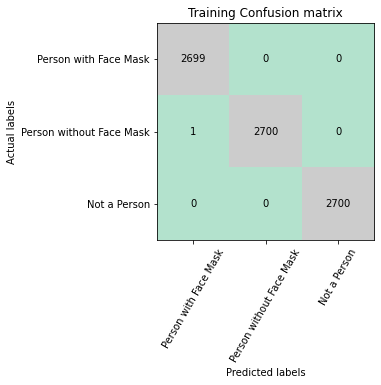

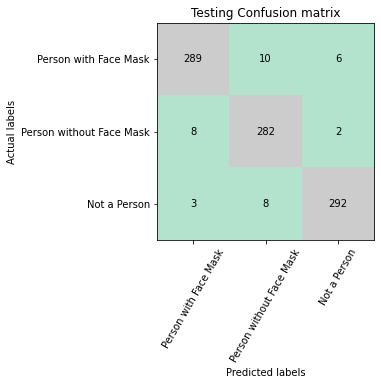

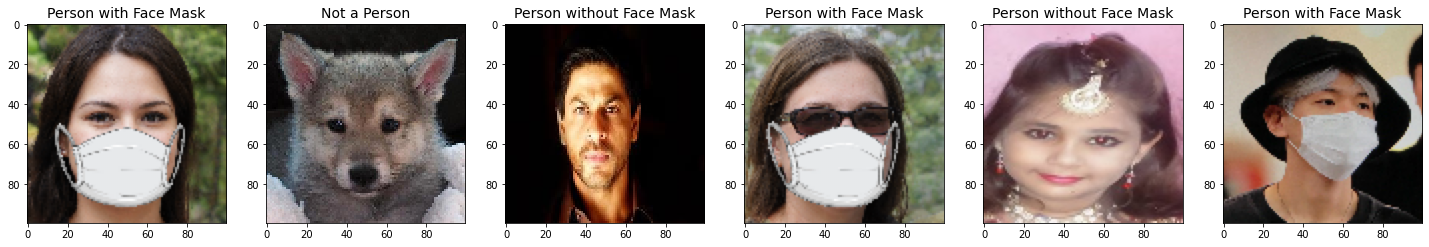


=== Generating Classification Report ===
Female Test Dataset Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       150
           1       0.97      0.95      0.96       150
           2       0.00      0.00      0.00         0

    accuracy                           0.96       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.96      0.96      0.96       300

=== Generating Confusion Matrix ===
=== Generating Predicted Results ===


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


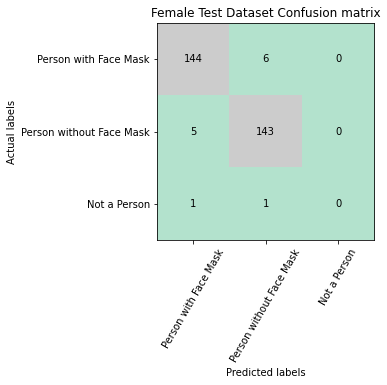

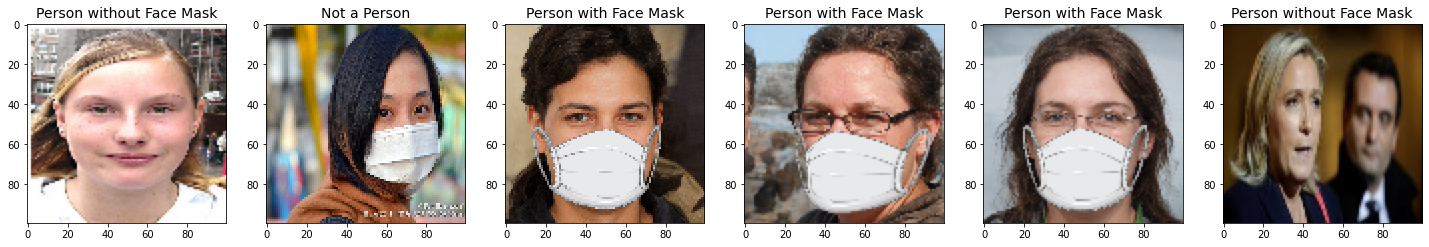


=== Generating Classification Report ===
Male Test Dataset Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.98      0.93      0.95       150
           2       0.00      0.00      0.00         0

    accuracy                           0.95       300
   macro avg       0.65      0.63      0.64       300
weighted avg       0.98      0.95      0.96       300

=== Generating Confusion Matrix ===
=== Generating Predicted Results ===


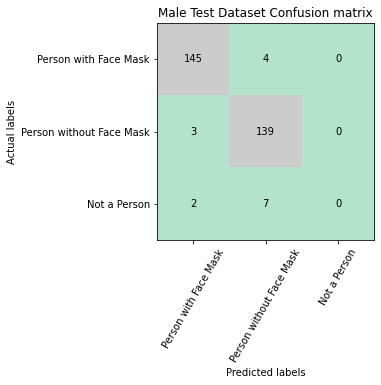

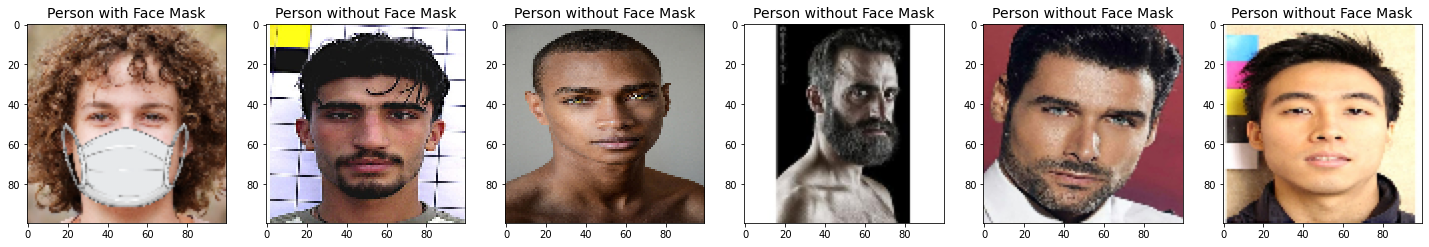

In [23]:
# If the value of is_data_preloaded
# is True which means program reads pre-loaded data from the directory, otherwise it generates
# the data and loads it. While the True value of is_model_saved parameter indicates that
# program reads model from the directory which is pre stored and if the parameter is set as 
# False then it creates new model, trains the model and then it becomes available for 
# further use such as in evaluation process.

run_program(is_data_preloaded=True, is_model_saved=True)